In [1]:
# demo de-noising using fhmm
import sys
sys.path.append("/Users/david/Documents/mastersCode/ubm")
print(sys.path)

['/Users/david/Documents/mastersCode/ubm/final/fhmm', '/Users/david/.conda/envs/ubm/lib/python310.zip', '/Users/david/.conda/envs/ubm/lib/python3.10', '/Users/david/.conda/envs/ubm/lib/python3.10/lib-dynload', '', '/Users/david/.conda/envs/ubm/lib/python3.10/site-packages', '/Users/david/Documents/mastersCode/ubm']


In [2]:
import librosa
import torchaudio
import numpy as np
import config
import os.path
import math
import os
import pathlib
import random
import torch
import utils
import warnings
import my_torch.torchio as tio
import torchaudio.functional as F
import torchaudio.transforms as T

In [3]:
# noise examples
fs = 4000

In [4]:

def noise_file_to_audio(noise_dir, sample_rate):
    effects = [
        ['remix', '1'],  # convert to mono
        ['rate', str(sample_rate)],  # resample
        ['gain', '-n']  # normalises to 0dB
    ]
    noise, sr = torchaudio.sox_effects.apply_effects_file(noise_dir, effects, normalize=True)
    return noise, sr

In [5]:
from whale.setup import get_data, constants, annotations

get_data_whale = get_data.GetDataBase(
    location_of_wav_file=constants.HUMPBACK_WAV_A,
    location_of_annotations=constants.SWOOPS_LABELS_A,
    annotations=annotations.AnnotationsAudacity(),
    window_length=0.025, frame_step=0.01, samples=False, sr=None)

whale_audio, _ = noise_file_to_audio(get_data_whale.location_of_wav_file, 4000)
whale_audio_numpy = whale_audio.numpy().flatten()

In [6]:
# log power seems to work better than magnitude
def get_feature(sample, nfft):
    return np.log(np.square(np.abs(librosa.stft(sample, n_fft=nfft)).T))

In [9]:
# create labels and data
whale_samples = []
whale_features = []
nfft = 256

for i in range(len(get_data_whale.annotations.annotations)):
    annot = get_data_whale.annotations.annotations[i]
    sample = whale_audio_numpy[annot.start:annot.end]
    whale_samples.append(sample)
    whale_features.append(get_feature(sample, nfft))

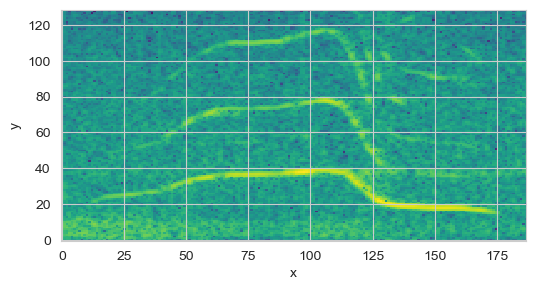

In [10]:
from final.useful import *
from hmmlearn.hmm import GaussianHMM
vis_helper(whale_features[0])
# train hmm
hmm_whale = GaussianHMM(20)

In [11]:
hmm_whale.fit(np.concatenate(whale_features))

GaussianHMM(n_components=20)

In [12]:
# [2] get noise files and update amplitude so snr is correct

noise_files = config.noise_db
noise_files_list = list(pathlib.Path(noise_files).glob('**/*.wav'))
noise_files_list.sort()
transformed_audio, transformed_audio_sr = noise_file_to_audio(noise_files_list[8], fs)
# tio.plot_waveform(transformed_audio)
# tio.plot_specgram(transformed_audio, sample_rate=transformed_audio_sr)
tio.play_audio(transformed_audio, sample_rate=transformed_audio_sr)

In [14]:
# time domain combine
import matplotlib.pyplot as plt
whale_sample = whale_samples[0]
utils.get_average_power(whale_sample, False, False)

0.0019521804219747643

0.0009784079047073359
0.00016643641543994785
10.692715992345587


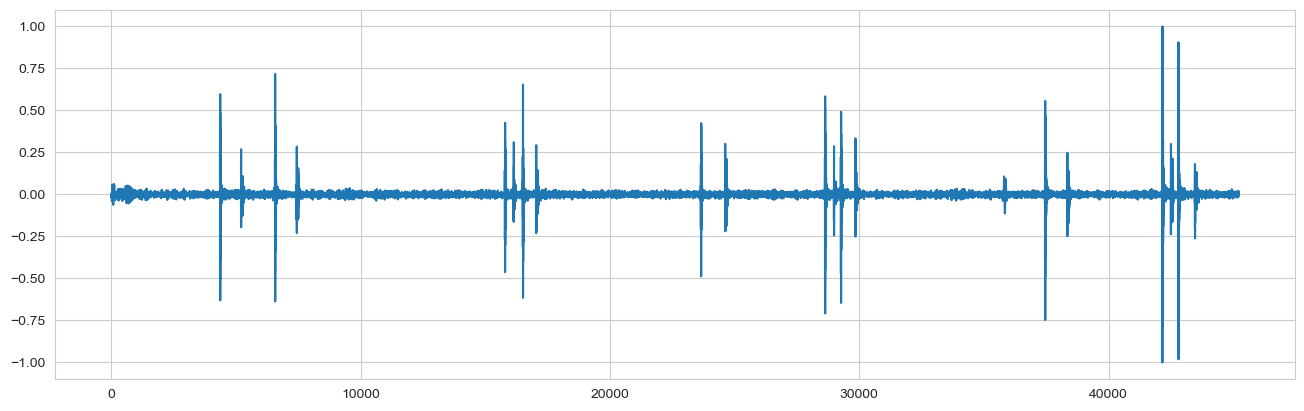

In [15]:
import noisey
# noise features
noise_time = transformed_audio.numpy().flatten()
snr = 3
print(noisey.get_noise_avg_watts(whale_sample, snr))
noise_reduction = 1
print(utils.get_average_power(noise_time[0:len(whale_sample)] * noise_reduction, False, False))
print(utils.snr(whale_sample, noise_time[0:len(whale_sample)] * noise_reduction))
noise_time_reduced = noise_time * noise_reduction
noise_time_reduced = noise_time_reduced[38000:]
plt.plot(noise_time_reduced)

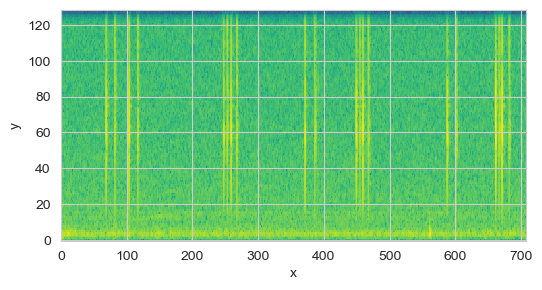

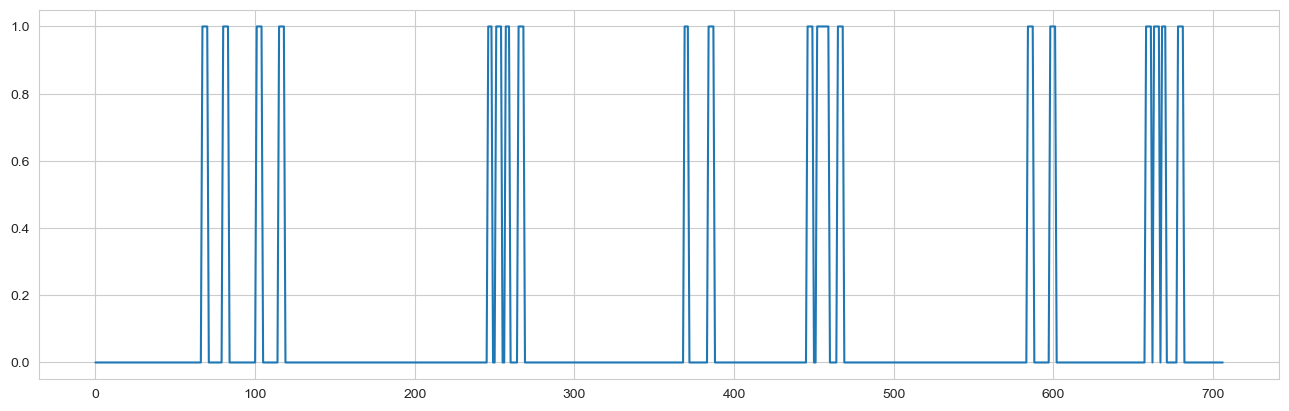

In [16]:
noise_feature = get_feature(noise_time_reduced, nfft)
vis_helper(noise_feature)
hmm_noise = GaussianHMM(2)
hmm_noise.fit(noise_feature)
utils.get_average_power(noise_time_reduced)
_, ss = hmm_noise.decode(noise_feature)
plt.plot(ss)

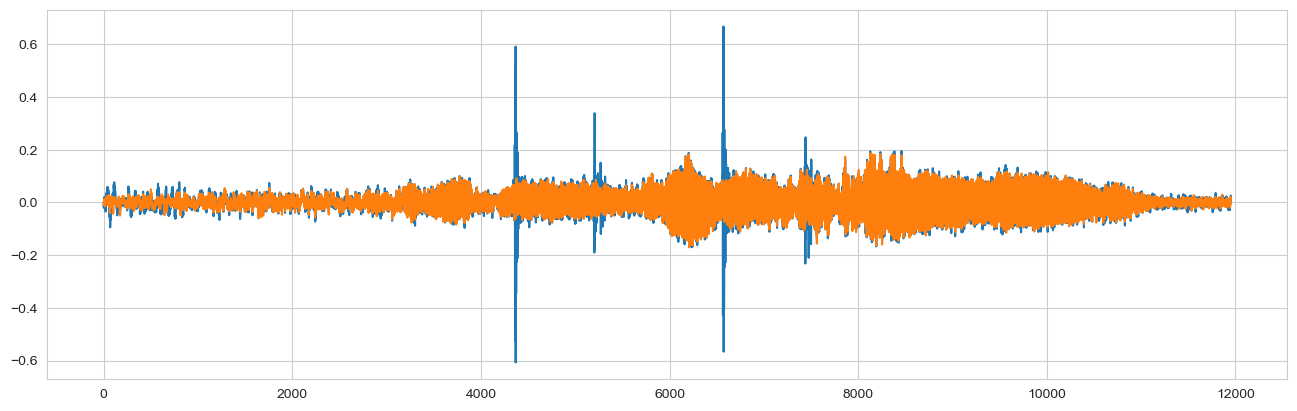

In [17]:
combined_sample_time_domain = whale_sample + noise_time_reduced[0:len(whale_sample)]
plt.plot(combined_sample_time_domain)
plt.plot(whale_sample)

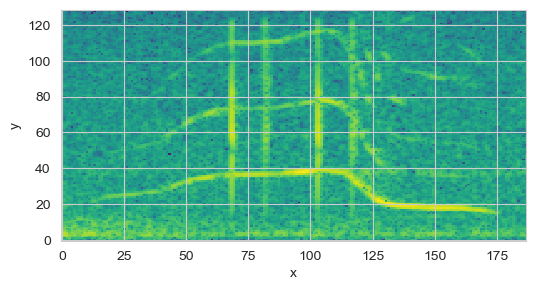

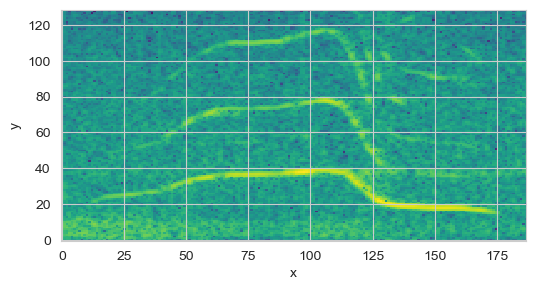

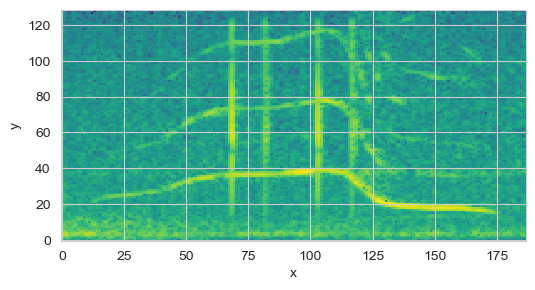

In [18]:
feature_combined = get_feature(combined_sample_time_domain, nfft)
whale_feature = whale_features[0]
vis_helper(feature_combined)
vis_helper(whale_feature)
vis_helper(np.maximum(noise_feature[:whale_feature.shape[0],:], whale_feature))

In [19]:
import hmmUtils
from importlib import reload
reload(hmmUtils)
ViterbiAlgorithmParallel = hmmUtils.doViterbiAlgorithmParallel(feature_combined, hmm_whale, hmm_noise)

In [40]:
reload(hmmUtils)
# switch to the


p1 = hmmUtils.inputParams(hmm_whale.means_, ViterbiAlgorithmParallel[1][0])
p2 = hmmUtils.inputParams(hmm_noise.means_, ViterbiAlgorithmParallel[1][1])

mask01, mask02 = hmmUtils.weinerFilter.getSoftMask(feature_combined, p1, p2, alpha=1)

whale_recovered = ((np.exp(feature_combined)) * mask01)
noise_recovered = ((np.exp(feature_combined)) * mask02)

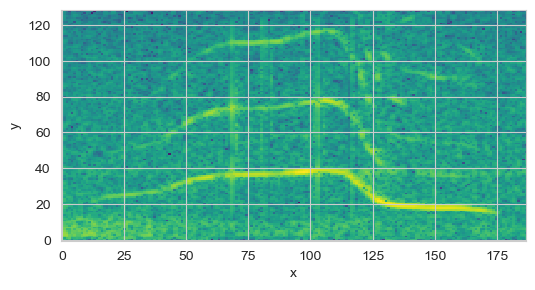

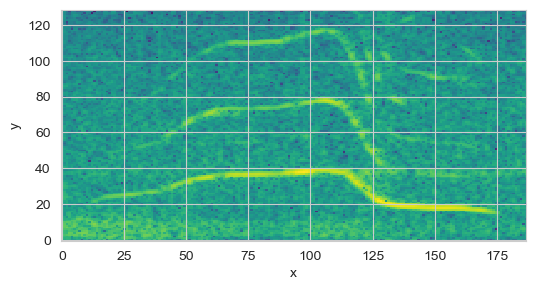

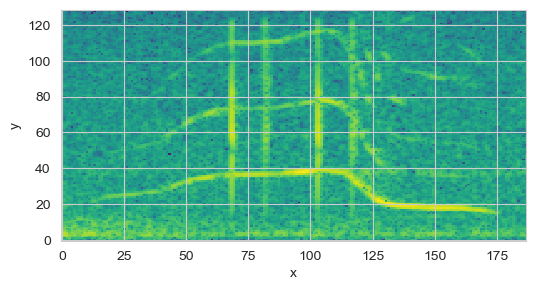

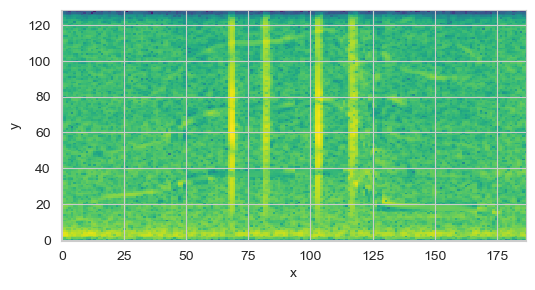

In [41]:
vis_helper(np.log(whale_recovered))
vis_helper(whale_feature)
vis_helper(feature_combined)
vis_helper(np.log(noise_recovered))

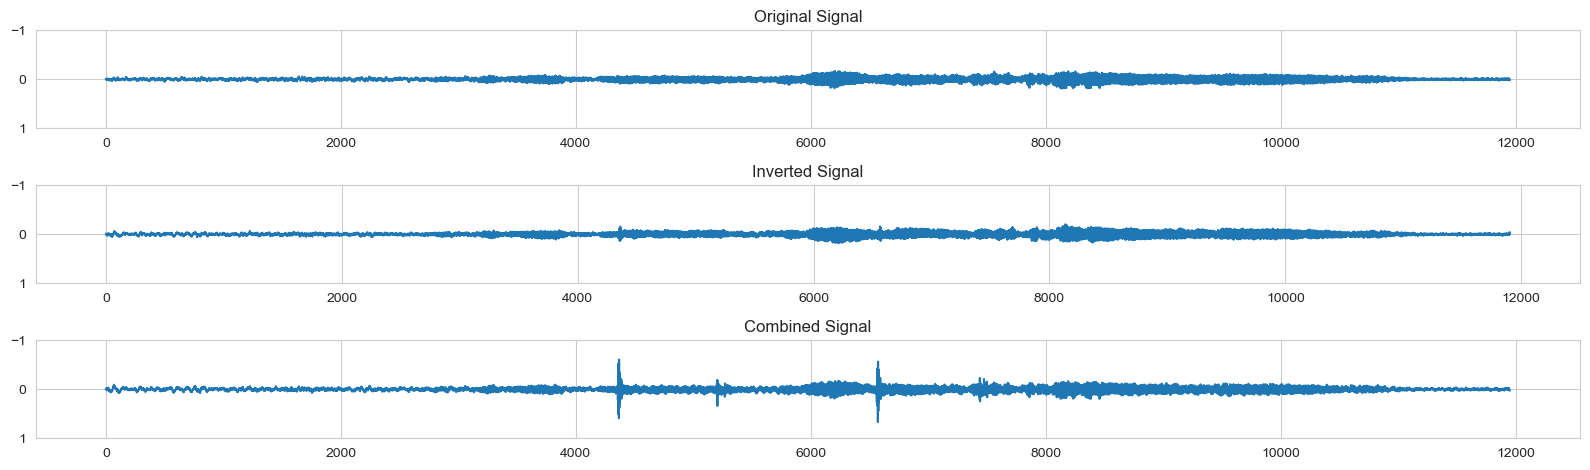

In [43]:
# listen to recovered signal

whale_recovered_stft = np.sqrt(whale_recovered)
whale_recovered_time_domain = librosa.griffinlim(whale_recovered_stft.T, n_fft=nfft)

plt.subplot(3, 1, 1)
plt.plot(whale_sample)
plt.title('Original Signal')
plt.ylim([1,-1])  # Set y-axis limits

# Plot inverted signal
plt.subplot(3, 1, 2)
plt.plot(whale_recovered_time_domain)
plt.title('Inverted Signal')
plt.ylim([1,-1])  # Set y-axis limits

plt.subplot(3, 1, 3)
plt.plot(combined_sample_time_domain)
plt.title('Combined Signal')
plt.ylim([1,-1])  # Set y-axis limits

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


In [201]:
whale_sample_tensor = torch.from_numpy(whale_sample[np.newaxis, ...])

tio.play_audio(whale_sample_tensor, fs)
tio.play_audio(torch.from_numpy(whale_recovered_time_domain[np.newaxis, ...]), fs)

tio.play_audio(torch.from_numpy(combined_sample_time_domain[np.newaxis, ...]), fs)



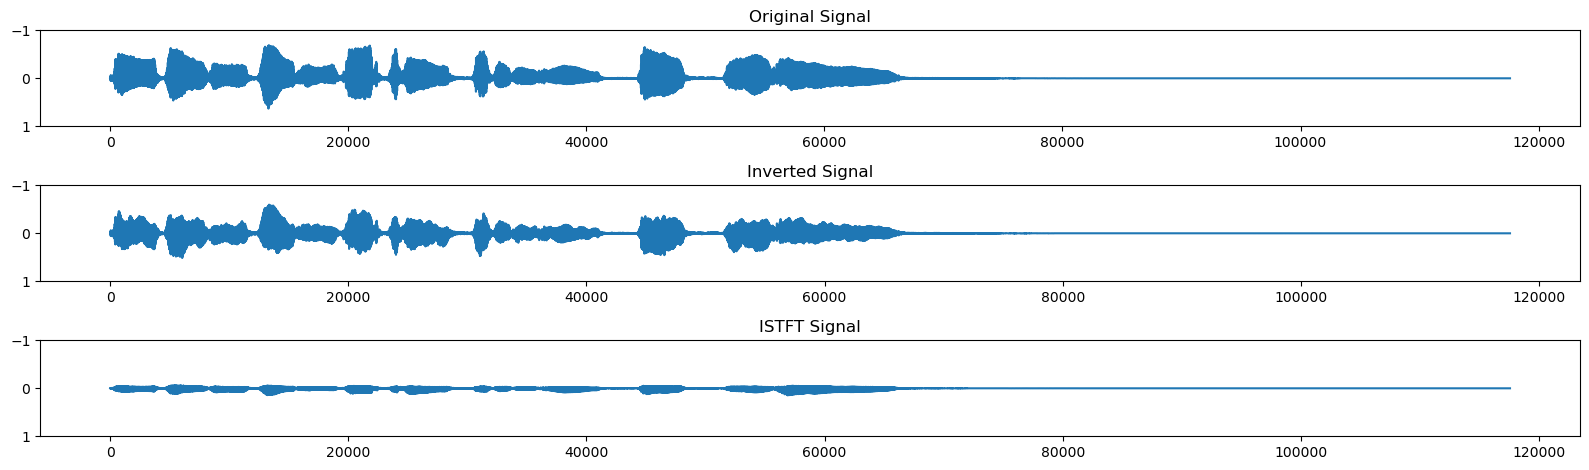

In [123]:
y, sr = librosa.load(librosa.ex('trumpet'))
# Get the magnitude spectrogram
S = np.abs(librosa.stft(y, n_fft=256))
# Invert using Griffin-Lim
y_inv = librosa.griffinlim(S, n_fft=256)
# Invert without estimating phase
y_istft = librosa.istft(S, n_fft=256)


# Plot original signal

import matplotlib.pyplot as plt

plt.subplot(3, 1, 1)
plt.plot(y)
plt.title('Original Signal')
plt.ylim([1,-1])  # Set y-axis limits

# Plot inverted signal
plt.subplot(3, 1, 2)
plt.plot(y_inv)
plt.title('Inverted Signal')
plt.ylim([1,-1])  # Set y-axis limits

# Plot ISTFT signal
plt.subplot(3, 1, 3)
plt.plot(y_istft)
plt.title('ISTFT Signal')
plt.ylim([1,-1])  # Set y-axis limits

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()